Постройте график, отражающий динамику удержания игроков на конец первой и второй недели — 7-й и 14-й дни. 

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

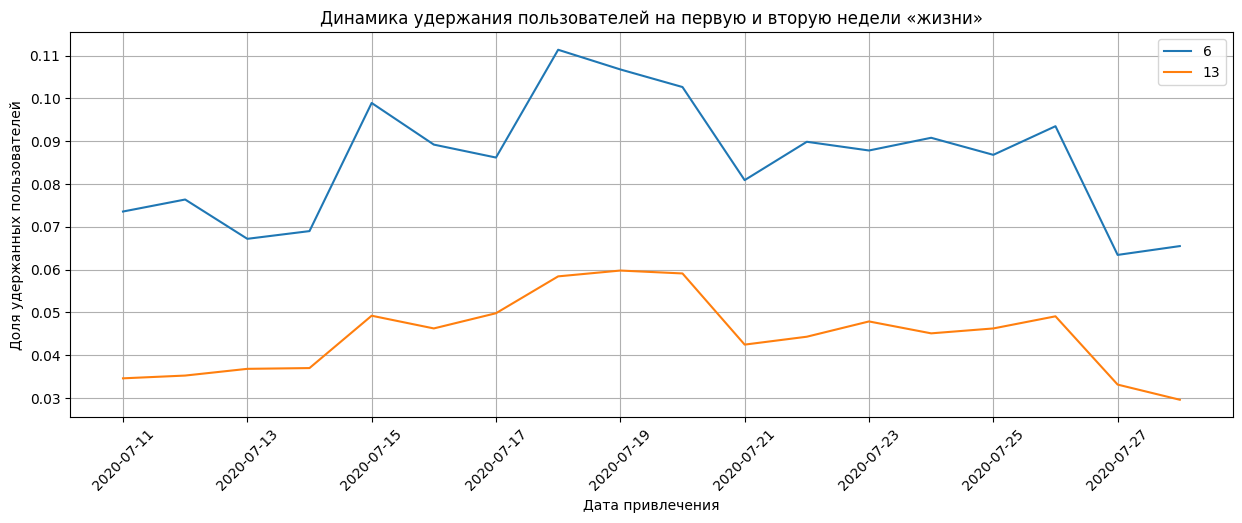

In [3]:
# функция для расчёта удержания
def get_retention(
    profiles, sessions, observation_date, horizon_days, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('dt')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='dt', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped


users = pd.read_csv('C:\\Users\\37544\\Downloads\\ch02_problems01_users.csv')   # профили
visits = pd.read_csv('C:\\Users\\37544\\Downloads\\ch02_problems01_visits.csv') # сессии

# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
visits['session_start'] = pd.to_datetime(visits['session_start'])

# доступный интервал привлечения пользователей
min_analysis_date = users['dt'].min()
observation_date = users['dt'].max()  # момент анализа

# горизонт анализа
analysis_horizon = 14

retention_raw, retention = get_retention(
    users, visits, observation_date, analysis_horizon
)

# постройте график истории изменений для 7-го и 14-го дней
# добавьте на график сетку, задав параметр grid
# установите размер графика 15 на 5, задав параметр figsize

report = retention[[6, 13]]

report.plot(grid=True, figsize=(15, 5))

plt.title('Динамика удержания пользователей на первую и вторую недели «жизни»')
plt.xlabel('Дата привлечения')
plt.xticks(rotation = 45)
plt.ylabel('Доля удержанных пользователей')
plt.show()